In [40]:
import numpy as np
import pandas as pd

import datetime
import time

import backtrader as bt
from backtrader.feeds import PandasData

%matplotlib inline

Starting Portfolio Value: 10000.00

2017-04-17T00:00:00,BUY CREATE, 1189.91
2017-04-17T00:00:00,Current Cash 10000.0
None
2017-04-18T00:00:00,SELL CREATE, 1201.94
2017-04-20T00:00:00,SELL CREATE, 1236.15
2017-04-21T00:00:00,SELL CREATE, 1249.99
2017-04-22T00:00:00,SELL CREATE, 1247.00
2017-04-28T00:00:00,SELL CREATE, 1353.34
2017-04-29T00:00:00,BUY CREATE, 1365.43
2017-04-29T00:00:00,Current Cash 16281.47224
None
2017-04-30T00:00:00,SELL CREATE, 1384.55
2017-05-04T00:00:00,SELL CREATE, 1563.39
2017-05-05T00:00:00,SELL CREATE, 1551.30
2017-05-06T00:00:00,BUY CREATE, 1585.39
2017-05-06T00:00:00,Current Cash 20774.29492
None
2017-05-07T00:00:00,BUY CREATE, 1609.57
2017-05-07T00:00:00,Current Cash 20774.29492
None
2017-05-10T00:00:00,BUY CREATE, 1794.99
2017-05-10T00:00:00,Current Cash 20774.29492
None
2017-05-11T00:00:00,BUY CREATE, 1837.93
2017-05-11T00:00:00,Current Cash 20774.29492
None
2017-05-12T00:00:00,SELL CREATE, 1695.61
2017-05-13T00:00:00,SELL CREATE, 1792.73
2017-05-14T00:00:0

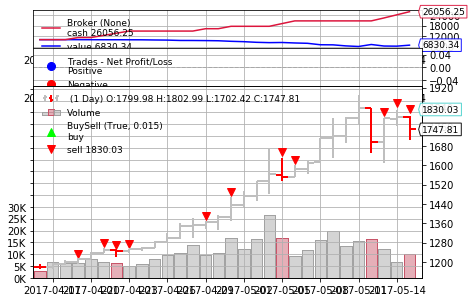

In [130]:
class PandasData_Signal(PandasData):
    lines = ('signal',)
    params = (('signal', 6), )

class TestStrategy(bt.Strategy):
    
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.datetime(0)
        print('%s,%s' % (dt.isoformat(),txt))
        
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datasignal = self.datas[0].signal

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
    def next(self):
        if self.datasignal[0] > 0.7:
            self.log('BUY CREATE, %.2f' % self.dataclose[0])
            print(self.log('Current Cash {}'.format(self.broker.get_cash())))
            self.order = self.buy(size=1000)
            
        if self.datasignal[0] < 0.3:
            self.log('SELL CREATE, %.2f' % self.dataclose[0])
            self.order = self.sell()


class TestsingleStrategy():
    def __init__(self):
        self.df = pd.read_csv('BackTest/tests/btc_test.csv')
        
        #because our file has like this as int
        self.df['Date'] = [int(time.mktime(datetime.datetime.strptime(x, '%m/%d/%Y').timetuple())) for x in self.df['Date']] 
        #convert timestamp to date
        self.df['Datetime'] = [datetime.datetime.fromtimestamp(x) for x in self.df['Date']]
        
        self.df = self.df.drop('Date', axis=1)
        
        np.random.seed(1)
        self.df['Signal'] = np.random.rand(self.df.shape[0])
        
        self.df = self.df[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Signal']]
        
    def test_Strategy(self):
        cerebro = bt.Cerebro()
        cerebro.broker.setcash(10000)
        cerebro.broker.setcommission(commission=0.001) # 0.1%
        
        print('Starting Portfolio Value: %.2f\n' % cerebro.broker.getvalue())
        
        data = PandasData_Signal(dataname=self.df, datetime=0, open=1, high=2, low=3, close=4, volume=5, signal=6)
        
        cerebro.adddata(data)
        cerebro.addstrategy(TestStrategy)
        
        cerebro.run()
        
        print('\nFinal Portfolio Value: %.2f\n'  % cerebro.broker.getvalue())
        
        cerebro.plot(iplot=False)
        
        
TestsingleStrategy().test_Strategy()